
<h1 id="Tutorial-8---Three-way-branch-migration-first-passage-times">Tutorial 8 - Three-way branch migration first passage times<a class="anchor-link" href="#Tutorial-8---Three-way-branch-migration-first-passage-times">¶</a></h1>



<p>Multistrand's "First Passage Time" mode can be used to get statistics on how long it takes to reach a certain state, or one of a set of defined states.   Here we compare two sequences for toehold-mediated three-way strand displacement.  Starting in with the incoming strand binding by the toehold only, we run simulations until either the incoming strand falls off again (a "failure") or the incumbent top strand is displaced and dissociates (a "success").  This is specified via Dissoc_Macrostate StopConditions that look for the incoming strand being in a complex by itself, or the incumbent strand being in a complex by itself, respectively.  We perform only 100 trials for each sequence, because that already takes around 10 minutes (most of which is design A).  Once that's done, for each sequence we have 100 trial results, each tagged with either "failure" or "success". We can look at histograms of how long such trajectories took, or alternatively tabulate what fraction of trajectories completed by a certain time.</p>


In [1]:
from multistrand.objects import *
from multistrand.options import Options, Literals
from multistrand.system import SimSystem

import numpy as np
import matplotlib
import matplotlib.pylab as plt


<p>We will do Multistrand simulations on two sequences, Design A and Design B.
These are taken from Schaeffer's PhD thesis, figure 7.4.<br/>
Design A has a hairpin and is slow / fails often, whereas Design B is fast.
(In Schaeffer's figure 7.4, Design A has the same sequence, but Design B is "ACCGCACCACGTGGGTGTCG".)</p>


In [4]:
def setup_threewaybm_comparison(trials=100, toehold_seq="GTGGGT",
                                bm_design_A="ACCGCACGTCCACGGTGTCG",
                                bm_design_B="ACCGCACGTCACTCACCTCG"):
    toehold = Domain(name="toehold", sequence=toehold_seq)
    branch_migration_A = Domain(name="bm_A", sequence=bm_design_A)
    branch_migration_B = Domain(name="bm_B", sequence=bm_design_B)

    substrate_A = toehold + branch_migration_A
    substrate_B = toehold + branch_migration_B
    incumbent_A = Strand(name="incumbent", domains=[branch_migration_A.C])
    incumbent_B = Strand(name="incumbent", domains=[branch_migration_B.C])

    incoming_A = substrate_A.C
    incoming_B = substrate_B.C

    # start with the full toehold bound
    start_complex_A = Complex(strands=[incoming_A, substrate_A, incumbent_A], structure=".(+)(+)")
    start_complex_B = Complex(strands=[incoming_B, substrate_B, incumbent_B], structure=".(+)(+)")

    complete_complex_A = Complex(strands=[incumbent_A], structure=".")
    complete_complex_B = Complex(strands=[incumbent_B], structure=".")

    failed_complex_A = Complex(strands=[incoming_A], structure="..")
    failed_complex_B = Complex(strands=[incoming_B], structure="..")

    # the "success" state
    complete_sc_A = StopCondition("complete", [(complete_complex_A, Literals.dissoc_macrostate, 0)])
    complete_sc_B = StopCondition("complete", [(complete_complex_B, Literals.dissoc_macrostate, 0)])

    # the "failure" state
    failed_sc_A = StopCondition("failed", [(failed_complex_A, Literals.dissoc_macrostate, 0)])
    failed_sc_B = StopCondition("failed", [(failed_complex_B, Literals.dissoc_macrostate, 0)])

    o1 = Options(simulation_mode="First Passage Time", num_simulations=trials, simulation_time=1.0,
                 dangles="Some", temperature=310.15, join_concentration=1e-6,  # 1 uM concentration
                 start_state=[start_complex_A], verbose=1)
    o1.stop_conditions = [complete_sc_A, failed_sc_A]
    o1.JSMetropolis37()

    o2 = Options(simulation_mode="First Passage Time", num_simulations=trials, simulation_time=1.0,
                 dangles="Some", temperature=310.15, join_concentration=1e-6,  # 1 uM concentration
                 start_state=[start_complex_B], verbose=1)
    o2.stop_conditions = [complete_sc_B, failed_sc_B]
    o2.JSMetropolis37()

    return o1, o2


<p>Once the simulations has run, we will want to show histograms of how long they took.</p>


In [6]:
def plot_histograms_complete_vs_failed(result_list, colors=['b','m'], figure=1):
    # separate based on which stop condition ended the simulation   ((( what if simulation ran out of time? )))
    times_complete = np.array([i.time for i in result_list if i.tag == 'complete'])
    times_failed = np.array([i.time for i in result_list if i.tag == 'failed'])
    neither = [i for i in result_list if not i.tag == 'complete' and not i.tag == 'failed']
    if len(neither)>0 :
        print("some trajectories did not finish, one way nor the other...")
        for i in neither :
            assert i.type_name=='Time'
            assert i.tag == None

    if len(times_complete)>0 and len(times_failed)>0 :
        min_time = np.min([np.min(times_complete),np.min(times_failed)])
        max_time = np.max([np.max(times_complete),np.max(times_failed)])
    else:
        if len(times_complete)>0 :
            min_time = np.min(times_complete)
            max_time = np.max(times_complete)
        if len(times_failed)>0 :
            min_time = np.min(times_failed)
            max_time = np.max(times_failed)
            
    plt.figure(figure)
    if len(times_complete)>0 :
        plt.hist(times_complete, 50, range=(min_time,max_time), color=colors[0], label="complete")
    if len(times_failed)>0 :
        plt.hist(times_failed, 50, range=(min_time,max_time), color=colors[1],rwidth=.5, label="failed")

    plt.title("Completion times for successful and failed trajectories, Design A")
    plt.xlabel("First Passage Time (s)",fontsize='larger')
    plt.ylabel("# of Trajectories",fontsize='larger')
    plt.yticks(fontsize='larger',va='bottom')
    plt.xticks(fontsize='larger')
    plt.legend(loc=0)
    plt.show()

In [7]:
def plot_histograms_two_designs(result_lists, colors=['magenta','b'], figure=1):
    times = []
    times.append(np.array([i.time for i in result_lists[0] if i.tag == 'complete']))
    times.append(np.array([i.time for i in result_lists[1] if i.tag == 'complete']))

    min_time = np.min([np.min(times[0]),np.min(times[1])])
    max_time = np.max([np.max(times[0]),np.max(times[1])])
    # the above might fail if any list is empty; min, max of empty is undefined

    plt.figure(figure)
    plt.hist(times[1], 50, range=(min_time,max_time), color=colors[1], label="Design B")
    plt.hist(times[0], 50, range=(min_time,max_time), color=colors[0], label="Design A", rwidth=.5)

    plt.title("Successful trajectories in two designs")
    plt.xlabel("First Passage Time (s)",fontsize='larger')
    plt.ylabel("# of Trajectories",fontsize='larger')
    plt.yticks(fontsize='larger',va='bottom')
    plt.xticks(fontsize='larger')
    plt.legend(loc=0)
    plt.show()

In [8]:
def plot_completion_graph(result_lists, colors=['b','r'], figure=1, labels=['Design A', 'Design B']):
    times = []
    percents = []
    for rl in result_lists:
        n = len(rl)
        t = [i.time for i in rl if i.tag == 'complete']
        t.sort()
        times.append(np.array(t))

        p = np.array(range(1,len(t)+1))
        p = 100 * p / n  # percentage of all trials, including ones that don't complete
        percents.append(p)

    plt.figure(figure)
    for t,p,c,label in zip(times,percents,colors,labels):
        plt.plot(t, p, color = c, linewidth=2.0, label=label)

    plt.xlabel("Simulation Time (s)",fontsize='larger')
    plt.ylabel("% of Trajectories Complete",fontsize='larger')
    plt.yticks([0,20,40,60,80,100],("0%","20%","40%","60%","80%","100%"),fontsize='larger',va='bottom')
    plt.xticks(fontsize='larger')
    plt.title( "Percentage of Total Trajectories Complete by a Given Time" )
    plt.legend(loc=0)
    plt.show()

In [9]:
def plot_completion_graph_complete_vs_failed(result_list, colors=['b','m'], figure=1, labels=['complete','failed']):
    n = len(result_list) # number of trials
    times = []
    percents = []
    for rl in ['complete','failed']:
        t = [i.time for i in result_list if i.tag == rl]
        t.sort()
        times.append(np.array(t))
        p = np.array(range(1,len(t)+1))
        p = 100 * p / n
        percents.append(p)
    # the last data points of each type should sum to 1.0 if all trajectories either fail or complete (rather than time out)

    plt.figure(figure)
    for t,p,c,label in zip(times,percents,colors,labels):
        plt.plot(t, p, color = c, linewidth=2.0, label=label)

    plt.xlabel("Simulation Time (s)",fontsize='larger')
    plt.ylabel("% of Trajectories Complete",fontsize='larger')
    plt.yticks([0,20,40,60,80,100],("0%","20%","40%","60%","80%","100%"),fontsize='larger',va='bottom')
    plt.xticks(fontsize='larger')
    plt.title( "Percentage of Total Trajectories Complete by a Given Time, Design A" )
    plt.legend(loc=0)
    plt.show()


<p>Now we are ready to run the simulations.  First we set up the molecules and options.  You might want to try different numbers of trials, or run it with different sequences.</p>


In [10]:
# The following two options are equivalent, since they are defaults
# o1,o2 = setup_threewaybm_comparison()
o1,o2 = setup_threewaybm_comparison(trials=100, toehold_seq="GTGGGT", bm_design_A="ACCGCACGTCCACGGTGTCG", bm_design_B="ACCGCACGTCACTCACCTCG")

# The same, but a longer toehold:
# o1,o2 = setup_threewaybm_comparison(trials=100, toehold_seq="GTGGGTAGGT", bm_design_A="ACCGCACGTCCACGGTGTCG", bm_design_B="ACCGCACGTCACTCACCTCG")

<p>Actually do the simulation</p>
<p>On my laptop, they take about 10 minutes for 100 trials. You might want to just do 10, for speed -- but the histograms below will look much better if you run 100 or more! Each simulation trial prints the complexes present when it stops including its energy, each preceeded by that simulation's random number seed.</p>

In [11]:
print()
print("Running Design A")
s=SimSystem(o1)
s.start()
print()
print("Running Design B")
s=SimSystem(o2)
s.start()


Running Design A

Running Design B


<p>All the above information is collected into the options objects <code>o1.interface.results</code> and <code>o2.interface.results</code>.  Before plotting histograms, let's look to see what kind of data is there.  (This next line ought to be skipped if you have run a lot of trials!)</p>

In [12]:
o1.interface.results

[(7399083224573482928, 17, 0.0005395277148016886, 'failed', result_type='status_line' ),
 (743871762, 17, 0.0007005147437487637, 'failed', result_type='status_line' ),
 (1281314274, 17, 0.0010168747471658798, 'failed', result_type='status_line' ),
 (1478757982, 17, 1.3610198430698512e-05, 'failed', result_type='status_line' ),
 (756741108, 17, 0.0003989589141694921, 'complete', result_type='status_line' ),
 (936597705, 17, 0.0003910759029165025, 'failed', result_type='status_line' ),
 (1283708803, 17, 0.000566051627143537, 'failed', result_type='status_line' ),
 (908146625, 17, 0.0007454544150329883, 'failed', result_type='status_line' ),
 (558844057, 17, 0.0002204156067526455, 'failed', result_type='status_line' ),
 (1956967623, 17, 0.00037391179651489705, 'complete', result_type='status_line' ),
 (644618394, 17, 0.00018199712840468964, 'failed', result_type='status_line' ),
 (1465162687, 17, 2.283826944706222e-06, 'failed', result_type='status_line' ),
 (1429582464, 17, 0.00059918572


<p>That information is printed in a more understandable format, if you ask via <code>print</code>.</p>


In [13]:
result_list1 = o1.interface.results 
result_list2 = o2.interface.results 
# look at a few things by hand, just to check
print(result_list1[0])

        Trajectory Seed [7399083224573482928]
        Result: Normal
        Completion Time: 0.0005395277148016886
        Completion Tag: failed



<p>The easiest thing to do is to separate results based on whether strand displacement occurred, or not.</p>


In [14]:
times_complete1 = np.array([i.time for i in result_list1 if i.tag == 'complete'])
times_failed1 = np.array([i.time for i in result_list1 if i.tag == 'failed'])
print("Design A: %d trajectories total, %d completed, %d failed." % (len(result_list1), len(times_complete1), len(times_failed1)))
  
times_complete2 = np.array([i.time for i in result_list2 if i.tag == 'complete'])
times_failed2 = np.array([i.time for i in result_list2 if i.tag == 'failed'])
print("Design B: %d trajectories total, %d completed, %d failed." % (len(result_list2), len(times_complete2), len(times_failed2)))

Design A: 100 trajectories total, 37 completed, 63 failed.
Design B: 100 trajectories total, 98 completed, 2 failed.



<p>Now let's go ahead and see the histograms.  OK, they don't look so interesting with just 10 trials.  Go back and change that to 100 and try again, if you didn't already...</p>


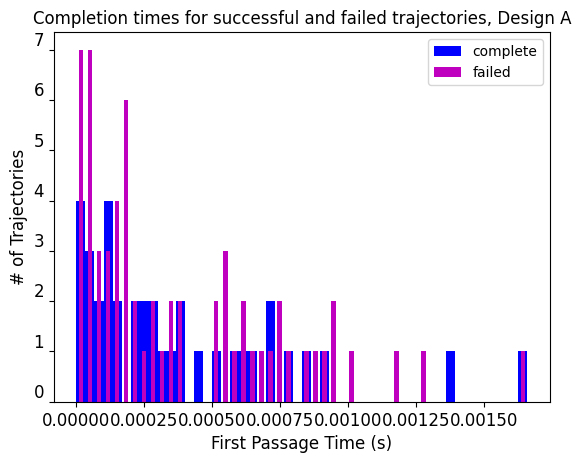

In [15]:
%matplotlib inline
plot_histograms_complete_vs_failed(o1.interface.results)

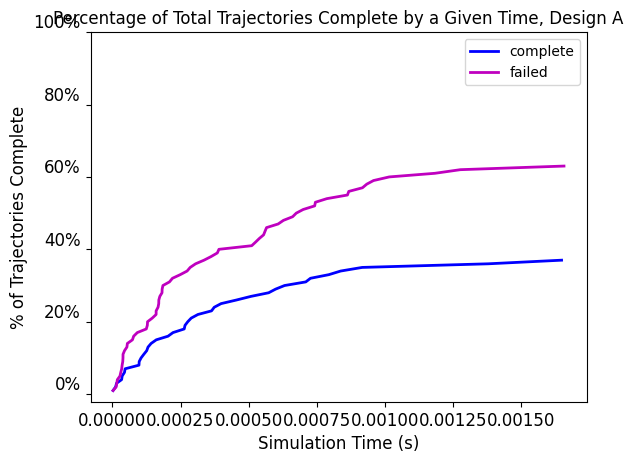

In [16]:
plot_completion_graph_complete_vs_failed(o1.interface.results)

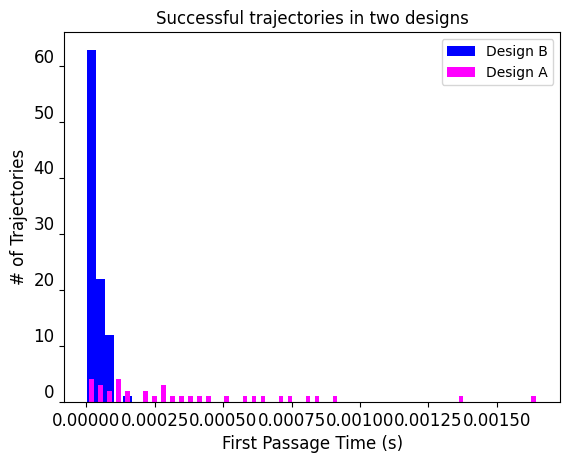

In [17]:
plot_histograms_two_designs([o1.interface.results, o2.interface.results])

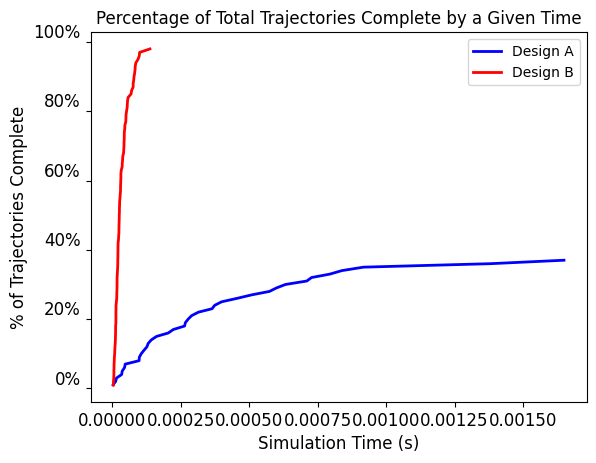

In [18]:
plot_completion_graph([o1.interface.results, o2.interface.results])